# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$ L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2 $$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

снчало надо вспомнить производные $\ln(1+x)$ и $\|x\|$
$$ \ln'(1+x) = \frac{x'}{1+x} $$
$$ \ln'(1+\exp(x)) = \frac{x' \cdot \exp(x)}{1+\exp(x)} $$
$$ \|x\|' = x'\operatorname{sign}(x) $$
теперь ищем градиет по $w$ и по $w_0$ $%вообще грустно что сделать они отдельные, можно же закинуть в одну переменную🙁$
$$ \nabla_w L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{-y_i x_i \cdot \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} + \gamma \operatorname{sign}(w) + 2\beta w $$
$$ \nabla_{w_0} L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{-y_i \cdot \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} $$

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
from numpy.linalg import norm

def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    """
    return gamma*norm(w, ord=1) + beta*norm(w) + np.sum(np.log(1 + np.exp(-y*(X @ w.T + w0))))/len(X)

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    """
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    """
    exp = np.exp(-y*(X @ w.T + w0))
    grad_w0 = -np.sum(exp / (1+exp) * y)/len(X)
    grad_w = -(exp / (1+exp) * y)/len(X) @ X + gamma*np.sign(w) + 2*beta*w
    return grad_w, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000):
        """
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        """
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.lr = self.learning_rate = lr
        self.classes_ = np.array([-1, 1])

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.loss_history = []
        X = np.array(X)
        y = np.array(y)

        uniq, inverse = np.unique(y, return_inverse=True)
        assert len(uniq) == 2
        if not np.array_equal(uniq, [-1, 1]):
            y = self.classes_[inverse]
            self.classes_ = uniq

        self.w0 = 1
        self.w = np.ones(X.shape[1])
        for _ in range(self.max_iter):
            gw, gw0 = self.calc_gradient(X, y)
            if np.linalg.norm(gw) < self.tolerance:
                break
            self.w -= gw * self.learning_rate
            self.w0 -= gw0 * self.learning_rate
            self.loss_history.append(self.calc_loss(X, y))

        return self

    def predict(self, X):
        """
        Function that returns the vector of predicted labels for each object from X
        """
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

    def predict_proba(self, X):
        """
        Function that estimates probabilities
        """
        tmp = X @ self.w + self.w0
        prob_y_eq_neg1 = 1 / (1 + np.exp(tmp))
        prob_y_eq_1 = 1 / (1 + np.exp(-tmp))
        return np.column_stack((prob_y_eq_neg1, prob_y_eq_1))
    
    def calc_gradient(self, X, y):
        return get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
    
    def calc_loss(self, X, y):
        return loss(X, y, self.w, self.w0, self.gamma, self.beta)

    def decision_function(self, X):
        return self.predict_proba(X)[:, 1]


In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred-.5, alpha=.4, colors=['red', 'green']) # 🍉
    plt.scatter(X[:,0], X[:,1], c=y)

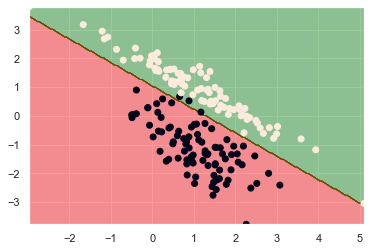

In [9]:
model = Logit(0, 0, lr=.5)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

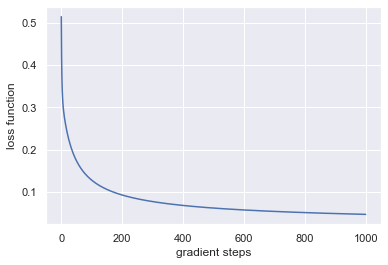

In [10]:
plt.ylabel('loss function')
plt.xlabel('gradient steps')
plt.plot(model.loss_history)
plt.show()

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC

rom = {
  "linear": {"arguments": dict(kernel='linear'), "color": 'C0'},
  # "poly deg=2": {"arguments": dict(kernel='poly', degree=2), "color": 'C5'},
  "poly deg=3": {"arguments": dict(kernel='poly', degree=3), "color": 'C2'},
  "poly deg=4": {"arguments": dict(kernel='poly', degree=4), "color": 'C3'},
  "rbf ɣ=0.25": {"arguments": dict(kernel='rbf', gamma=0.25), "color": 'C4'},
  "rbf ɣ=0.5": {"arguments": dict(kernel='rbf', gamma=0.5), "color": 'C1'},
  "sigmoid": {"arguments": dict(kernel='sigmoid'), "color": 'C6'},
}

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=122)

def calc_scores(dest, clf, X, y):
  ypred = clf.predict(X)
  dest["accurancy"].append(accuracy_score(y, ypred))
  dest["roc_auc"].append(roc_auc_score(y, ypred))
  dest["f1"].append(f1_score(y, ypred))

reg_coeff = np.logspace(-2, 2, num=10)
for ker in rom.values():
  ker["test"] = {"accurancy": [], "roc_auc": [], "f1": [], "linestyle": '-'}
  ker["train"] = {"accurancy": [], "roc_auc": [], "f1": [], "linestyle": '--'}
  for reg in reg_coeff:
    clf = SVC(**ker["arguments"], C=reg)
    clf.fit(Xtrain, ytrain)
    calc_scores(ker["test"], clf, Xtest, ytest)
    calc_scores(ker["train"], clf, Xtrain, ytrain)

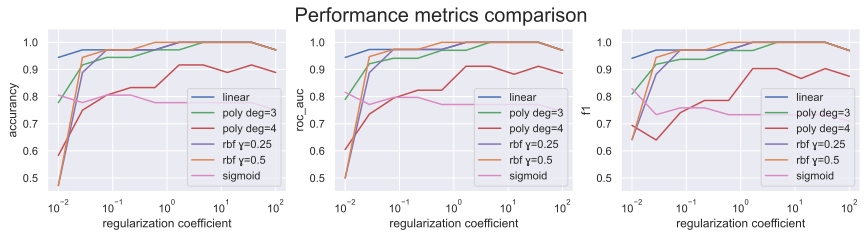

In [12]:
import matplotlib.axes
%config InlineBackend.figure_formats = ['svg']

def plot(ax: matplotlib.axes.Axes, ker="linear", set=None, score="accurancy"):
  ax.set_xscale("log")
  ax.set_ylabel(score)
  ax.set_xlabel("regularization coefficient")
  ax.set_ylim(0.45, 1.05)

  label = ker
  if set:
    label = ker + " " + set
  else:
    set = "test"

  ax.plot(reg_coeff, rom[ker][set][score], rom[ker][set]["linestyle"], label=label, c=rom[ker]["color"])
  pass

fig, axs = plt.subplots(1,3, figsize=(11.9, 3))
fig.subplots_adjust(left=0.04, right=0.99)
fig.suptitle("Performance metrics comparison", fontsize=20)
for ax, score in zip(axs, ["accurancy", "roc_auc", "f1"]):
  for k in rom:
    plot(ax, k, score=score)
  ax.legend()
plt.show()

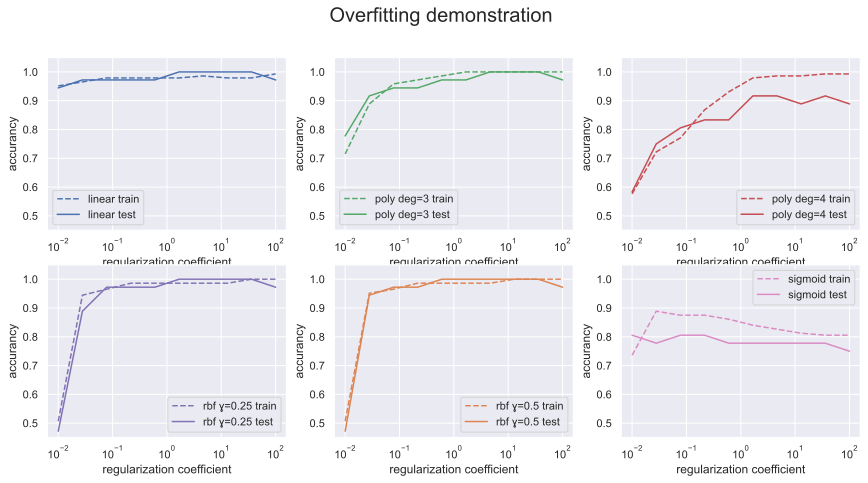

In [13]:
def flatten(t):
  return [item for sublist in t for item in sublist]

fig, axs = plt.subplots(2,3, figsize=(11.9, 7))
fig.subplots_adjust(left=0.04, right=0.99)
fig.suptitle("Overfitting demonstration", fontsize=20)
for ax, k in zip(flatten(axs), rom.keys()):
  plot(ax, k, set="train")
  plot(ax, k, set="test")
  ax.legend()
plt.show()

На коэффициент регуляризации больше всех реагирует полиномный кёрнел четвёртого порядка, а все остальные доситигают 100%ной точности на почти всех значениях $C$, кроме сигмойда, которой вообще ведёт себя очень плохо и $C$ ему совсем не помогает.
Что насчёт оверфитинга, он есть в сигмойде и в томже `poly deg=4`. (на графике пунктирная линия выше обычной)

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [14]:
import re
from glob import glob

# awk $'length>=15 && /[.,?!…–\-:;()«»"—]/ {gsub(/\u00a0/, " "); $1=$1; print}'
def load_text(dir):
  res = []
  for file in glob(f"prose/{dir}/*.txt"):
    for line in open(file):
      line = line.strip()
      if len(line) < 15:
        continue
      if not re.search('[.,?!…–\-:;()«»"—]', line):
        continue
      res.append(line)
  return re.sub(r'\s+', ' ', ' '.join(res))

def sentences(text):
  # code "inspired" by https://github.com/mediacloud/sentence-splitter
  text = re.sub(r'([.?!…])(?: [-–—]| --)? («?[A-ZА-ЯЁÀ-Ý][a-zа-яёà-ÿ]*)', '\\1\n\\2', text)
  text = text.replace('…', '...')
  return [e for e in text.split('\n') if len(e) >= 15]

romen = ["Dostoevsky", "Chekhov", "Pushkin", "Turgenev", "Gorky", "Herzen"]
romru = ["Достоевский", "Чехов", "Пушкин", "Тургенев", "Горький", "Герцен"]
romsize = [30_000, 15_000, 7_000, 20_000, 40_000, 3_000]

np.random.seed(122)
col1 = []
col2 = []
for en, ru, l in zip(romen, romru, romsize):
  col1 += list(np.random.choice(sentences(load_text(en)), l, replace=False))
  col2 += [ru]*l

df = pd.DataFrame(data={"sentence": col1, "author": col2})

In [15]:
df

,sentence,author
0,"Весь город назвали, а меня нет!",Достоевский
1,Я только махнул рукой.,Достоевский
2,"Тут надо плакать, а не куражиться"".",Достоевский
3,"Да, ты, может быть, это знаешь», – прибавил он...",Достоевский
4,"Совсем, совсем, я тебе скажу, исчез прежний до...",Достоевский
...,...,...
114995,Что тебе? - отвечала Глафира.,Герцен
114996,"Сельский священник, ходивший поздравить Бельто...",Герцен
114997,Тут-то я вас и ждал.,Герцен
114998,"Вот отчего люди, провозглашавшие республику, с...",Герцен


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2

nltk.download('punkt')
nltk.download('stopwords')

lemmatizer = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import string 

stop_words = set(stopwords.words('russian'))
stop_words |= set(string.punctuation)
stop_words |= set(string.digits)
stop_words |= {'…', '...', '..'}

def lemma(word):
  return lemmatizer.parse(word)[0].normal_form.lower()

def lemma_sent(s):
  return [lemma(t.lower()) for t in word_tokenize(s) if t.lower() not in stop_words and t.isalpha()]

def lemma_sents(data):
  return [lemma_sent(sent) for sent in data]

df["lemma"] = lemma_sents(df["sentence"])

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

joined_lemma = [' '.join(e) for e in df["lemma"]]

def columnify(sparsematrix):
  t = np.asarray(sparsematrix.todense())
  return [t[i] for i in range(t.shape[0])]

df["bag"] = columnify(CountVectorizer(max_features=1000).fit_transform(joined_lemma))
df["tfidf"] = columnify(TfidfVectorizer(max_features=1000).fit_transform(joined_lemma))

In [20]:
df

,sentence,author,lemma,bag,tfidf
0,"Весь город назвали, а меня нет!",Достоевский,"[весь, город, назвать]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Я только махнул рукой.,Достоевский,"[махнуть, рука]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Тут надо плакать, а не куражиться"".",Достоевский,"[плакать, куражиться]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"Да, ты, может быть, это знаешь», – прибавил он...",Достоевский,"[это, знать, прибавить, проникновенный, раздум...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Совсем, совсем, я тебе скажу, исчез прежний до...",Достоевский,"[ты, сказать, исчезнуть, прежний, доктор, кото...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
114995,Что тебе? - отвечала Глафира.,Герцен,"[ты, отвечать, глафира]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
114996,"Сельский священник, ходивший поздравить Бельто...",Герцен,"[сельский, священник, ходить, поздравить, бель...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
114997,Тут-то я вас и ждал.,Герцен,[ждать],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
114998,"Вот отчего люди, провозглашавшие республику, с...",Герцен,"[отчий, человек, провозглашать, республика, сд...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


`bag of words` просто считает количество слов, а `tfidf` ещё их нормирует на частоту этого слова во всём датасете.
Тоесть получается что, когда у нас в `bag of words` $0$ в `tfidf` тоже будет $0$, а когда в `bag of words` $1$ в `tfidf` будет какое-то дробное число.

In [20]:
print(sum(np.sum(np.vstack(df["bag"]), axis=1) == 0), "нулевых предложений")
df = df.loc[np.sum(np.vstack(df["bag"]), axis=1) != 0]

7019 нулевых предложений


У нас после векторизации получилось очень много предложений, в которых нет не одного слова из самых популярных 1000, и поэтому в их векторной репрезентации одни нули. Такие предложения невозможно склацифицировать к какому либо автору, и им нечего делать в датасете. Их придётся удалить. 

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [21]:
authorpair = ("Достоевский", "Горький")
df2 = df[(df["author"] == authorpair[0]) | (df["author"] == authorpair[1])]
count1 = sum(df2["author"] == authorpair[0])
count2 = sum(df2["author"] == authorpair[1])
factor = max(count1, count2)/min(count1, count2)
print(f"У {authorpair[0]}а {count1} предложений, а у {authorpair[1]}а – {count2}")
print(f"Баланс неочень… один класс в {factor:.2f} раза больше другого")

У Достоевскийа 28314 предложений, а у Горькийа – 37429
Баланс неочень… один класс в 1.32 раза больше другого


In [22]:
# я выбрал tfidf, потому что это более sophisticated алгоритм, и зачемто же мы его считали🙃 
y = np.array([-1, 1])[(df2["author"] == authorpair[0]) + 0]
X = np.vstack(df2["tfidf"])
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=69)

In [23]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# код из семенара
def show_results(test_y, pred, name="SVC", labels=authorpair[::-1]):
    print(f"{name} Precision:  {precision_score(test_y, pred, average='macro', zero_division=0):.2f}")
    print(f"{name} Recall:     {recall_score(test_y, pred, average='macro'):.2f}")
    print(f"{name} F1-measure: {f1_score(test_y, pred, average='macro'):.2f}")
    print(f"{name} Accuracy:   {accuracy_score(test_y, pred):.2f}")
    # print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.title(f"Confusion matrix for {name}")
    plt.show()

#### Сначала прогоняем SVC из sklearn-а

SVC Precision:  0.77
SVC Recall:     0.76
SVC F1-measure: 0.76
SVC Accuracy:   0.77


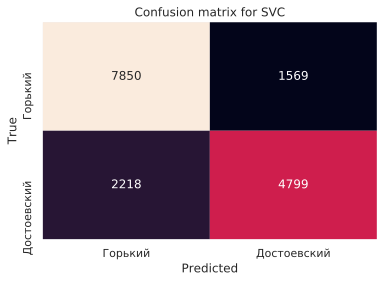

In [24]:
clfsvc = SVC(kernel='linear', C=1, random_state=420)
clfsvc.fit(Xtrain, ytrain)
ypred = clfsvc.predict(Xtest)
show_results(ytest, ypred, "SVC")

SVC on training data Precision:  0.78
SVC on training data Recall:     0.77
SVC on training data F1-measure: 0.77
SVC on training data Accuracy:   0.78


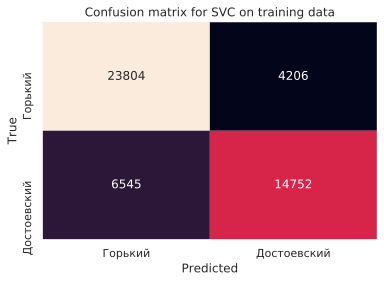

In [25]:
show_results(ytrain, clfsvc.predict(Xtrain), "SVC on training data")

In [26]:
from sklearn.model_selection import cross_validate

cvclf = SVC(kernel='linear', C=1, random_state=420)
scores = cross_validate(cvclf, Xtrain, ytrain, cv=5, scoring='roc_auc')
scores

{'fit_time': array([1052.08774757, 1052.06847811, 1058.21385455, 1053.52146435,
        1055.27611804]),
 'score_time': array([207.26501155, 205.84223866, 206.81292343, 206.81111312,
        207.48642182]),
 'test_score': array([0.84988123, 0.84109511, 0.84864892, 0.84628326, 0.85400778])}

#### А потом наш Logistic Regression, тоесть Logit

Logit Precision:  0.65
Logit Recall:     0.63
Logit F1-measure: 0.63
Logit Accuracy:   0.65


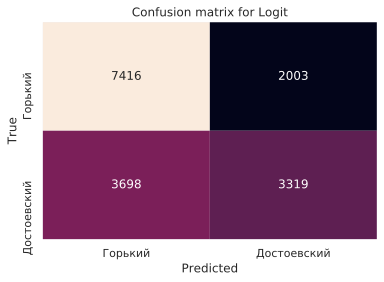

In [27]:
clf = Logit(0, 0, lr=.7)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
show_results(ytest, ypred, "Logit")

Logit on training data Precision:  0.65
Logit on training data Recall:     0.63
Logit on training data F1-measure: 0.63
Logit on training data Accuracy:   0.65


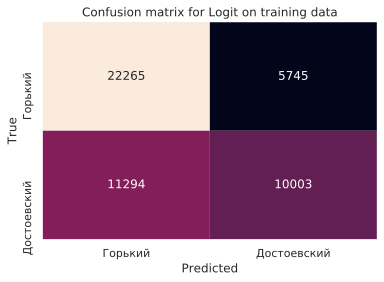

In [28]:
show_results(ytrain, clf.predict(Xtrain), "Logit on training data")

In [29]:
cvclf = Logit(0, 0, lr=.7)
scores = cross_validate(cvclf, Xtrain, ytrain, cv=5, scoring='roc_auc')
scores

{'fit_time': array([38.74202132, 38.64661908, 38.43767357, 38.63636303, 38.63344264]),
 'score_time': array([0.00792837, 0.00786281, 0.00782347, 0.00782895, 0.00779581]),
 'test_score': array([0.680916  , 0.67970975, 0.68829647, 0.68445313, 0.69501054])}

Результаты классификаторов, мягко говоря, получились плохие.
Матрицы путаницы (конфьюжена), в хороших сличиях, когда путаницы (конфьюжена) относительно мало, должны выглядить диагонально.
То есть оба значения на диагонали должны быть больше обоих значений на на диагонали (плучается что на обратной диагонали, тк матрица 2х2).
Это означает что ошибочных результатов всегда меньше чем верных.
Хотя, в случиях когда у нас сильно несбалансированны классы, например при диагностики редких заболеваний, допустимо что вероятность false positive-а больше чем true positive-а, но к нам это не относится, тк классы у нас относительно сбалансированны. 
Хорошая матрица путаницы (конфьюжена) выглядит так:

<center><code style="white-space: pre-wrap; font-family: consolas, monospace;"
>┌───┬───┐
│ 9 > 1 │
├─v─┼─^─┤
│ 1 < 9 │
└───┴───┘</code></center>

А у нас матрицы путаницы (конфьюжена) не хорошие. 🙁
В них всегда false Горького больше чем true Достоевского.
И все метрики поулчаются гдето между $0.6$ и $0.7$.
To put this in perspective, рандомный классификатор будет довать метрики $0.5$, и наша модель получается только на $20\%$ лучше полного рандома…

Библиотечный Support Vector Classifier дал нам лучшие резальтаты и красивые матрицы путаницы (конфьюжена) а также метрики по $0.8$. Он молодец.

Спойлер: сделав GridSeaech мы выясним, что надо было брать `Logit(1, 0)` а не `Logit(0, 0)`, и тогда он станет сравним с SVC.

#### Теперь начинается больно от GridSearch-а

In [30]:
from sklearn.model_selection import GridSearchCV

# если тут не поставить max_iter и n_jobs=-1 он будет считать 10 часов 😨
params = {'C': [0.1, 1, 10], 'kernel': ["linear", "poly", "rbf"]}
gscv = GridSearchCV(SVC(max_iter=10000), params, scoring='roc_auc', cv=3, n_jobs=-1)
gscv.fit(Xtrain, ytrain)
gscv.best_params_

{'C': 1, 'kernel': 'linear'}

In [31]:
from mpl_toolkits.mplot3d import Axes3D

def destringify_array(arr):
  if type(arr[0]) == str:
    return np.arange(len(arr))
  else:
    return arr

def plot3d(gscv, title=None):
  keys = list(gscv.best_params_.keys())
  xarr = destringify_array(gscv.param_grid[keys[0]])
  yarr = destringify_array(gscv.param_grid[keys[1]])
  xshape = len(xarr)
  yshape = len(yarr)
  
  z = np.reshape(gscv.cv_results_["mean_test_score"], (xshape,yshape)).T
  mesh = np.meshgrid(xarr, yarr)

  ax = plt.axes(projection="3d")

  ax.set_xlabel(keys[0])
  ax.set_xticks(xarr)
  ax.set_xticklabels(gscv.param_grid[keys[0]])
  ax.set_ylabel(keys[1])
  ax.set_yticks(yarr)
  ax.set_yticklabels(gscv.param_grid[keys[1]])
  ax.set_zlabel("Score")
  ax.set_title(title)

  ax.scatter3D(*mesh, z, c="green")
  ax.plot_surface(*mesh, z, alpha=0.3)
  plt.show()

def plot4d(gscv, title=None):
  keys = list(gscv.best_params_.keys())
  xarr = destringify_array(gscv.param_grid[keys[0]])
  yarr = destringify_array(gscv.param_grid[keys[1]])
  warr = destringify_array(gscv.param_grid[keys[2]])
  xshape = len(xarr)
  yshape = len(yarr)
  wshape = len(warr)
  
  z = np.reshape(gscv.cv_results_["mean_test_score"], (xshape,yshape,wshape))
  mesh = np.meshgrid(yarr, xarr)

  ax = plt.axes(projection="3d")

  ax.set_xlabel(keys[0])
  ax.set_xticks(xarr)
  ax.set_xticklabels(gscv.param_grid[keys[0]])
  ax.set_ylabel(keys[1])
  ax.set_yticks(yarr)
  ax.set_yticklabels(gscv.param_grid[keys[1]])
  ax.set_zlabel("Score")
  ax.set_title(title)

  ax.scatter3D(*mesh[::-1], z[:,:,0], c="green")
  ax.plot_surface(*mesh[::-1], z[:,:,0], alpha=0.3)
  plt.show()

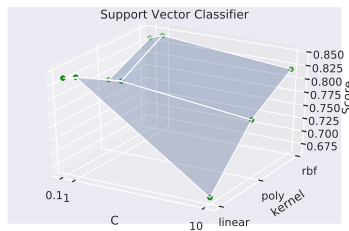

In [32]:
plot3d(gscv, "Support Vector Classifier")

In [33]:
prams = {'lr': [0.01, 0.1, 0.7], 'beta': [0, 0.1, 1, 2], 'gamma': [0, 0.1, 1, 2]}
gscv2 = GridSearchCV(Logit(), prams, scoring='roc_auc', cv=3, n_jobs=-1)
gscv2.fit(Xtrain, ytrain)
gscv2.best_params_

{'beta': 1, 'gamma': 0, 'lr': 0.01}

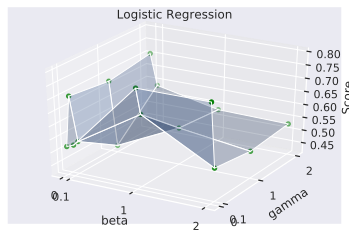

In [34]:
plot4d(gscv2, "Logistic Regression")

Параметр `learning_rate`, по какой-то неведомой причине, совсем не влияет на метрику ROC_AUC.
Ко всем остальным параметрам модели чуствительны, но хаотично: даже потратив пять часов на гридсёрч, у нас неполусчилось найти такие параметры, чтобы ROC_AUC был больше того, с которого мы начинали. Получилось найти только самые плохие комбинации параметров, а самый лучший мало чем отличается от того, который мы получили тыкнув здравым смыслом в пространство всех параметров. 

Хотя, если внимательно посмотреть на график, что easier said then done, потому что 3d графики вообще сложны к восприятию, особенно если их нельзя вращять и они рендерятся на cpu (у меня уже от них глаза болят), можно заметить, что для Logistic Regression в точках $\beta \ge 1,\, \gamma=0$ и $\beta = 0.1$ результаты получаются сильно лучше (на $20\%$) изначальных. 

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [35]:
logit_proba = clf.decision_function(Xtest)
svc_proba = clfsvc.decision_function(Xtest)

In [36]:
def find_threshold(proba, name="Logistic Regression", desiredFPR=0.3):
  fpr, tpr, threshold = roc_curve(ytest, proba)

  plt.title(f"ROC curve plot for {name}")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.plot(fpr, tpr, zorder=10)
  plt.plot([desiredFPR, desiredFPR], [0, 1], zorder=10) # нам в условие написали что false positive rate нужен 30%

  idx = np.argmin(np.abs(fpr - desiredFPR)) - 1 # вычитаем 1 чтобы ТОЧНО было меньше 30%
  plt.scatter([fpr[idx]], [tpr[idx]], c='red', zorder=11)
  return threshold[idx]

def predict_with_threshold(proba, threshold):
  return np.where(proba < threshold, -1, 1)

def check_false_positive_rate(test_y, pred):
  mat = confusion_matrix(test_y, pred, labels=[1, -1])
  return mat[1,0]/sum(mat[1])

def check_threshold(proba, name="Logistic Regression"):
  threshold = find_threshold(proba, name)
  pred = predict_with_threshold(proba, threshold)
  fpr = check_false_positive_rate(ytest, pred)
  print(f"Got {fpr*100:.2f}% false positive rate for {name}")

Got 29.99% false positive rate for Logistic Regression


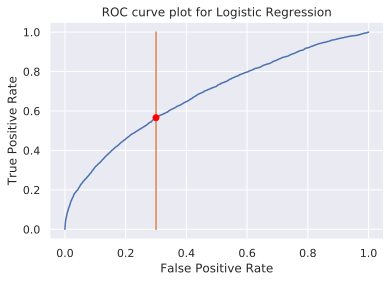

In [37]:
check_threshold(logit_proba, "Logistic Regression")

Got 29.99% false positive rate for SVC


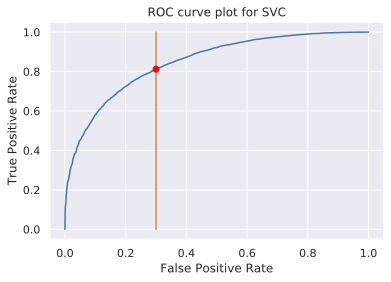

In [38]:
check_threshold(svc_proba, "SVC")

У SVC получилась более выпуклая кривая, потому что чем лучше класификатор, тем выпуклеее его ROC кривая.

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [39]:
from sklearn.multiclass import OneVsRestClassifier

# баланнсируем классы, тк у нас теперь они соовсем разных размеров
dfs = [df[df["author"] == k] for k in romru]
minlen = min(len(df) for df in dfs)
df2 = pd.concat([df[:minlen] for df in dfs])

X1train, X1test, y1train, y1test = train_test_split(np.vstack(df2["tfidf"]), df2["author"], test_size=0.25, random_state=69)

ovr = OneVsRestClassifier(Logit(0, 0, lr=15, max_iter=1000, tolerance=1e-6), n_jobs=-1)
ovr.fit(X1train, y1train)
y1pred = ovr.predict(X1test)

Multiclass Logit Precision:  0.41
Multiclass Logit Recall:     0.41
Multiclass Logit F1-measure: 0.41
Multiclass Logit Accuracy:   0.41


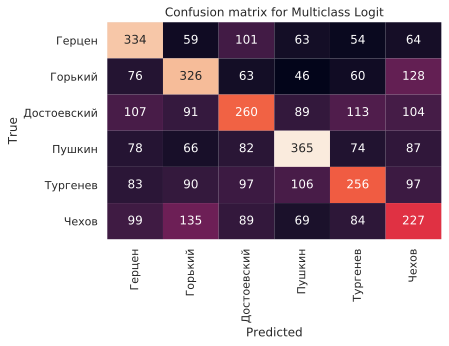

In [40]:
show_results(y1test, y1pred, "Multiclass Logit", sorted(romru))

In [41]:
scores = cross_validate(ovr, X1train, y1train, cv=5, scoring='roc_auc_ovr')
scores

{'fit_time': array([52.1108017 , 52.13429713, 52.10834193, 52.13136148, 52.15676975]),
 'score_time': array([0.02975917, 0.03819323, 0.03610659, 0.03845501, 0.03348207]),
 'test_score': array([0.73908462, 0.74327128, 0.73144474, 0.73996203, 0.74481453])}

In [42]:
prams = {'estimator__beta': [0, 0.1, 1], 'estimator__gamma': [0, 0.1, 1]}
ovr1 = OneVsRestClassifier(Logit(0, 0, lr=0.7, max_iter=1000, tolerance=1e-6), n_jobs=-1)
gscvovr = GridSearchCV(ovr1, prams, scoring='roc_auc_ovr', cv=3, n_jobs=-1)
gscvovr.fit(Xtrain, ytrain)
gscvovr.best_params_

{'estimator__beta': 0.1, 'estimator__gamma': 0}

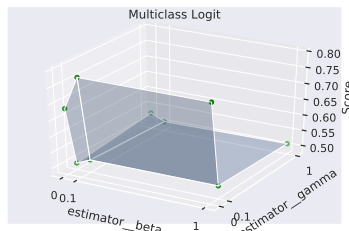

In [43]:
plot3d(gscvovr, "Multiclass Logit")

Модель выдаёт красивые диагональные матрицы путаницы (конфьюжена) и метрики в районе $0.75$ на кроссвалидации, не смотря на то что она обучается довольно быстро. Гридсёрч нам как всегда не дал никакой полезной информации.